In [1]:
# multi-headed cnn model
from numpy import mean
from numpy import std
from numpy import dstack
import numpy as np
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/inertial_signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/home/luishengjie/workspace/har/data/uci_har_dataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/home/luishengjie/workspace/har/data/uci_har_dataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


In [3]:
def cm_analysis(y_true, y_pred, labels, classes, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
                
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

# cm_analysis(y_test, y_pred, model.classes_, ymap=None, figsize=(10,10))

In [4]:
def train_model(trainX, trainy):
    verbose, epochs, batch_size = 0, 100, 32
    callbacks = [EarlyStopping(monitor='val_loss', patience=18)]
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # Head 1 
    inputs1 = Input(shape=(n_timesteps, n_features))
    conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1)
    conv1_2 = Conv1D(filters=128, kernel_size=3, activation='relu')(conv1_1)
    drop1 = Dropout(0.5)(conv1_2)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    
    # Head 2
    inputs2 = Input(shape=(n_timesteps, n_features))
    conv2_1 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs2)
    conv2_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(conv2_1)
    
#     conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2_2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    
    # Head 3
    inputs3 = Input(shape=(n_timesteps, n_features))
    conv3_1 = Conv1D(filters=128, kernel_size=11, activation='relu')(inputs3)
    conv3_2 = Conv1D(filters=128, kernel_size=11, activation='relu')(conv3_1)
    
#     conv3 = Conv1D(filters=128, kernel_size=11, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3_2)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)  
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # Interpretation
    dense1 = Dense(512, activation='relu')(merged)
    dense2 = Dense(n_outputs*4, activation='relu')(dense1)
    outputs = Dense(n_outputs, activation='softmax')(dense2)
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs=outputs)
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit([trainX,trainX,trainX], trainy, validation_split=0.33,callbacks=callbacks, 
              epochs=epochs, batch_size=batch_size, verbose=verbose)    

    print(history.history.keys())
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

def test_model(testX, testy, model, classes, repeats=1):
    pred = model.predict([testX, testX, testX])
    predy = pred.argmax(axis=-1)
    testy = testy.argmax(axis=-1)
    labels = [i for i in range(len(classes))]
    cm_analysis(testy, predy, labels, classes, ymap=None, figsize=(10,10))
    matrix = confusion_matrix(testy, predy)
    print(matrix) 
    
def get_model_accuracy(testX, testy, model, batch_size=32, repeats=10):
    scores = []
    for r in range(repeats):
        _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
        score = accuracy * 100.0
        scores.append(score)
        
    summarize_results(scores)
    
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [6]:
trainX, trainy, testX, testy = load_dataset()
print(trainX.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 128, 9)


(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


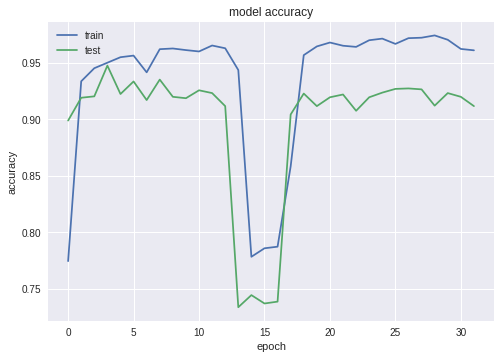

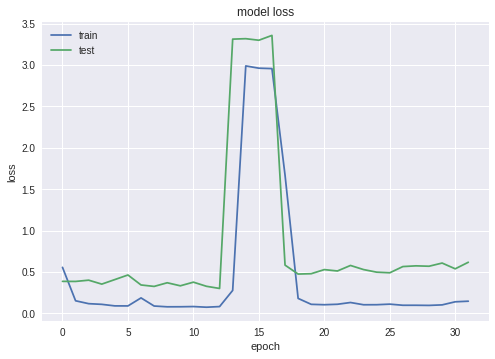

In [5]:
# run the experiment
# run_experiment()

trainX, trainy, testX, testy = load_dataset()
model = train_model(trainX, trainy)

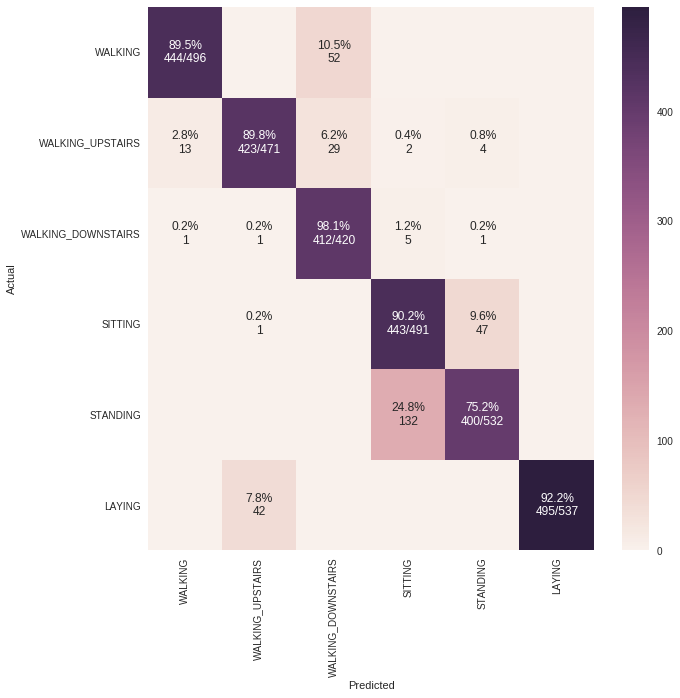

[[444   0  52   0   0   0]
 [ 13 423  29   2   4   0]
 [  1   1 412   5   1   0]
 [  0   1   0 443  47   0]
 [  0   0   0 132 400   0]
 [  0  42   0   0   0 495]]
[88.802171700033938, 88.802171700033938, 88.802171700033938, 88.802171700033938, 88.802171700033938, 88.802171700033938, 88.802171700033938, 88.802171700033938, 88.802171700033938, 88.802171700033938]
Accuracy: 88.802% (+/-0.000)


In [11]:
CLASSES = ['Crab', 'Idle', 'Jamesbond', 'Mermaid', 'Raffles', 'Snake']

ACTIVITIES = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', ]
test_model(testX, testy, model, ACTIVITIES)
get_model_accuracy(testX, testy, model)

In [7]:
"""[92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535]
Accuracy: 92.433% (+/-0.000)"""

'[92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535, 92.43298269426535]\nAccuracy: 92.433% (+/-0.000)'

In [12]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

tf.train.write_graph(frozen_graph, "models", "har_uci.pb", as_text=False)

model.save('models/har_uci.h5')

INFO:tensorflow:Froze 118 variables.
Converted 118 variables to const ops.


In [13]:
from keras.models import load_model
import time
model_deploy = load_model('models/har_uci.h5')

In [14]:
X_test1 = np.array(trainX[1]).reshape((1, trainX.shape[1], trainX.shape[2]))
y_test1 = np.array(trainy[1])
time_arr = []
pred_arr = []
for i in range(10):
    X_test1 = np.array(testX[i]).reshape((1, testX.shape[1], testX.shape[2]))
    y_test1 = np.array(testy[i])
    
    start = time.time()
    pred = model_deploy.predict([X_test1, X_test1, X_test1])
    predy = pred.argmax(axis=-1)
    y_test1 = y_test1.argmax(axis=-1)
    end = time.time()
    time_arr.append(end - start)
    pred_arr.append([predy, y_test1])
    
print(time_arr)
print('avg time:', np.mean(time_arr))

[0.10912370681762695, 0.010119438171386719, 0.009628057479858398, 0.009560108184814453, 0.008701324462890625, 0.008890867233276367, 0.008836984634399414, 0.008775949478149414, 0.009229898452758789, 0.009309530258178711]
avg time: 0.0192175865173


In [15]:
start = time.time()
pred = model_deploy.predict([X_test1, X_test1, X_test1])
predy = pred.argmax(axis=-1)
y_test1 = y_test1.argmax(axis=-1)
end = time.time()
print(end - start)


0.015819072723388672


In [16]:
print(end)

1555614140.0558338
